In [1]:
import os
import platform
import pandas as pd
import cv2 as cv
import json
import numpy as np
import tensorflow as tf


from tqdm import tqdm
from glob import glob, iglob
from matplotlib import image, pyplot as plt, patches

from sys import path
path.insert(0, '..')
import utill

2022-03-15 17:37:56.692507: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 17:37:56.692665: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [19]:
with open('../assets/dataset/gt_train.txt') as file:
  data = json.load(file)

with open('../assets/data_train.txt') as file:
  data_train = json.load(file)

with open('../assets/data_val.txt') as file:
  data_val = json.load(file)

print(f'Data length: {len(data)}')
print(f'Data train length: {len(data_train)}')
print(f'Data val length: {len(data_val)}')


Data length: 110000
Data train length: 67201
Data val length: 860


In [7]:
two = ['motorcycle', 'bicycle']
four = ['car', 'pickup_truck', 'work_van']
multi = ['articulated_truck', 'single_unit_truck', 'bus']

In [20]:
for data in data_train:
  new_objects = []
  for vehicle in data['objects']:
    if vehicle['class'] in two:
      vehicle['class'] = 'two-wheeled_vehicle'

    if vehicle['class'] in four:
      vehicle['class'] = 'four-wheeled_vehicle'
    
    if vehicle['class'] in multi:
      vehicle['class'] = 'multi-wheeled_vehicle'
      
    if vehicle['class'] != 'pedestrian':
      new_objects.append(vehicle)

  data['objects'] = new_objects

In [22]:
print(len(data_train))
print(data_train[10])

67201
{'filename': '00070939.jpg', 'image-size': [480, 720], 'objects': [{'class': 'four-wheeled_vehicle', 'x': 0.20277777777777778, 'y': 0.2625, 'w': 0.12638888888888888, 'h': 0.125}, {'class': 'four-wheeled_vehicle', 'x': 0.03333333333333333, 'y': 0.19791666666666666, 'w': 0.02361111111111111, 'h': 0.03125}, {'class': 'four-wheeled_vehicle', 'x': 0.23194444444444445, 'y': 0.1, 'w': 0.043055555555555555, 'h': 0.03333333333333333}, {'class': 'four-wheeled_vehicle', 'x': 0.12638888888888888, 'y': 0.2125, 'w': 0.10416666666666667, 'h': 0.11041666666666666}, {'class': 'four-wheeled_vehicle', 'x': 0.6597222222222222, 'y': 0.1875, 'w': 0.15694444444444444, 'h': 0.11041666666666666}, {'class': 'four-wheeled_vehicle', 'x': 0.06666666666666667, 'y': 0.20833333333333334, 'w': 0.029166666666666667, 'h': 0.05}, {'class': 'four-wheeled_vehicle', 'x': 0.0875, 'y': 0.2, 'w': 0.06111111111111111, 'h': 0.08541666666666667}, {'class': 'multi-wheeled_vehicle', 'x': 0.09583333333333334, 'y': 0.1104166666

In [74]:
def filtter_data(data, threshold):
  leak = []
  ndata = []
  data_train = data
  for f in data_train:
    objects = {}
    for c in f['objects']:
      if c['class'] in objects:
        objects[c['class']] += 1
      else:
        objects[c['class']] = 1
    f['objects'] = objects

  for f in data_train:
    if 'car' in list(f['objects'].keys()):
      if f['objects']['car'] >= threshold:
        leak.append(f)

  leak = [x['filename'] for x in leak]

  for id in range(len(data)):
    if data[id]['filename'] not in leak:
      ndata.append(data[id])
  
  return ndata

In [76]:
dt = filtter_data(data_train, 15)

In [79]:
print(dt[0])

{'filename': '00095813.jpg', 'image-size': [480, 720], 'objects': {'pickup_truck': 1, 'motorized_vehicle': 1}}


In [25]:
with open('../assets/new_data_train.txt', 'w') as file:
    json.dump(data_train, file)

In [14]:
def export_gt(image_notation, image_folder_path, export_path):
  for line in image_notation:
    filename = os.path.join(image_folder_path, line['filename'])
    img = line['image-size']
    filename = filename.split(os.sep)[-1].split('.')[0]
    output_path = os.path.join(export_path, filename+'.txt')

    with open(output_path, 'w') as gt_file:
      for object in line['objects']:
        x1 = round(object['x'] * img[1])
        y1 = round(object['y'] * img[0])
        x2 = round(x1 + (object['w'] * img[1]))
        y2 = round(y1 + (object['h'] * img[0]))
        gt_file.write('{0} {1} {2} {3} {4}\n'.format(object['class'], x1, y1, x2, y2))

{'four-wheeled_vehicle': 195408, 'multi-wheeled_vehicle': 25405, 'motorized_vehicle': 25743, 'two-wheeled_vehicle': 3942, 'non-motorized_vehicle': 2320}
[('non-motorized_vehicle', 2320), ('two-wheeled_vehicle', 3942), ('multi-wheeled_vehicle', 25405), ('motorized_vehicle', 25743), ('four-wheeled_vehicle', 195408)]


/home/hadioz/development/python/counting-car/notebook/../utill.py:475: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(window_title)


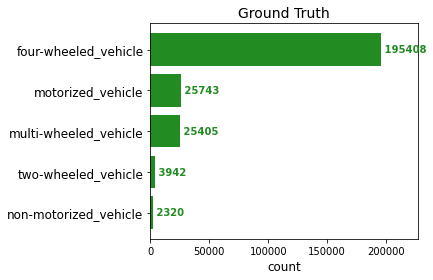

In [24]:
dr_files_list = sorted(glob(os.path.join('../assets/gt_train', '*.txt')))
classes = {}
for text_file in dr_files_list:
  lines = utill.read_txt_to_list(text_file)
  for line in lines:
    class_name = line.split()[0]
    if class_name in classes:
      classes[class_name] += 1
    else:
      classes[class_name] = 1

cl_name = list(classes.keys())
print(classes)

utill.draw_plot_func(
                classes,
                len(classes),
                "gt-info",
                "Ground Truth",
                "count",
                "./ground-truth-info.jpeg",
                True,
                "forestgreen",
                '',)

In [23]:
export_gt(data_train, '../assets/dataset/train', '../assets/gt_train')